# NLP tf-idf pipeline with Apache Spark

In [1]:
%matplotlib inline
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from timeit import default_timer as timer
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, ArrayType
from timeit import default_timer as timer
import time
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start
        
def visualize_data(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    sns.boxplot(x='latency',y='value',data=dd, orient="v")
    plt.show()
    return perf_df, dd 

In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']
punct_regex_expression = "[!\"#$%&()*+-.\/\\:;<=>?@[\]^_`{|}\\t\\n\',~—]"

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfs/anirband/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Setting up the spark cluster

In [4]:
conf = (SparkConf().setMaster("local[*]")
                .setAppName("SparkVectorizer")
                .set('spark.driver.memory', '300G')
                .set('spark.driver.maxResultSize', '20G')
                .set('spark.network.timeout', '7200s')
                .set('spark.local.dir', './u01/tmp'))
#                .set('spark.executor.cores', '20'))

sc = SparkContext(conf=conf)
# sc.setLogLevel("ERROR")
spark = SparkSession(sc)
print(sc._conf.getAll()) # check context settings

21/08/03 18:28:36 WARN Utils: Your hostname, dgx05 resolves to a loopback address: 127.0.0.1; using 10.33.227.155 instead (on interface enp1s0f0)
21/08/03 18:28:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/03 18:28:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/03 18:28:36 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


[('spark.driver.maxResultSize', '20G'), ('spark.driver.host', '10.33.227.155'), ('spark.app.startTime', '1628040516925'), ('spark.executor.id', 'driver'), ('spark.driver.port', '38445'), ('spark.local.dir', './u01/tmp'), ('spark.rdd.compress', 'True'), ('spark.network.timeout', '7200s'), ('spark.app.name', 'SparkVectorizer'), ('spark.serializer.objectStreamReset', '100'), ('spark.driver.memory', '300G'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.app.id', 'local-1628040517675'), ('spark.ui.showConsoleProgress', 'true')]


## Helper Functions

In [5]:
def read_data(spark, parquet_path, persist_flag=True):
    data = spark.read.parquet(parquet_path)
    if persist_flag:
        data.write.format("noop").mode("overwrite").save()
    return data

def text_preprocessor(data, column_name, PUNCTUATIONS, STOPWORDS, persist_flag=True):
    data = data.na.drop(subset=[column_name])
    data = data.withColumn(column_name,f.lower(f.col(column_name)))
    data = data.withColumn(column_name,f.regexp_replace(f.col(column_name), """[!"#$%&()*+-.\/\\:;<=>?@\[\]^_`{|}\t\n\',~—]""", ' '))
    data = data.withColumn(column_name,f.trim(f.col(column_name)))
    tokenizer = Tokenizer(inputCol=column_name, outputCol="words")
    data = tokenizer.transform(data)                  
    stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=STOPWORDS)
    data = stopwordsRemover.transform(data)
    if persist_flag:
        data.write.format("noop").mode("overwrite").save()
    return data

def hashing_vectorizer(data, persist_flag):
    hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=2**20)
    data = hashingTF.transform(data)
    if persist_flag:
        data.write.format("noop").mode("overwrite").save()
    return data

def tfidf_transformer(data, persist_flag):
    idf = IDF(inputCol="rawFeatures", outputCol="finalFeatures").fit(data)
    data = idf.transform(data)
    if persist_flag:
        data.write.format("noop").mode("overwrite").save()
    return data

def execute_full_pipeline(n, i, spark, parquet_path, worker_counts=[1], samples=1, result_path="./results.pkl", persist_flag=True):
    sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
    with SimpleTimer() as timer:
        data = read_data(spark, parquet_path, persist_flag)
    sample_record["data_read"]=timer.elapsed
    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    
    with SimpleTimer() as timer:
        data = text_preprocessor(data, "review_body", PUNCTUATIONS, STOPWORDS, persist_flag)
    sample_record["data_preprocessing"]=timer.elapsed
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    
    with SimpleTimer() as timer:
        data = hashing_vectorizer(data, persist_flag)
    sample_record["hashing_vectorizer"]=timer.elapsed
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    
    with SimpleTimer() as timer:
        data = tfidf_transformer(data, persist_flag=True)
    sample_record["tfidf_transformer"]=timer.elapsed
    
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")
    return data, sample_record
    

## Benchmarking Code

In [ ]:
def performance_numbers(parquet_path, worker_counts=[1], samples=1, result_path="./results.pkl", persist_flag=True):
    """
    Main function to perform the performance sweep
    """
    overall_perf_result = {}
    
    for n in worker_counts: 
        overall_perf_result[n]={"sample_run_results": []}
        
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, sample_record = execute_full_pipeline(n, i, spark, parquet_path, worker_counts=[1], samples=1, result_path=result_path, persist_flag=persist_flag)                
            sample_record["overall"]=overalltimer.elapsed
            sample_record["nrows"]=  data.count()
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed}s")
            overall_perf_result[n]["sample_run_results"].append(sample_record)
    
    with open(result_path, "wb") as file:
        pickle.dump(overall_perf_result, file)

In [6]:
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
samples = 5
worker_counts = [1]
result_path = f"./results/result_poc_nlp_spark_{dataset}_persist.pkl"

## Benchmark latency by materializing the intermediate dataframe(s) in every stage

In [7]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, persist_flag=True)

Workers:1, Sample Run:0, Finished loading data in 23227293387s


Workers:1, Sample Run:0, Finished preprocessing data in 90812437810s


Workers:1, Sample Run:0, Finished fitting HashVectorizer in 221542942472s


21/08/03 18:37:05 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:0, Finished fitting IDF Transformer in 460485375621s


 20%|██████████████████████████████████▌                                                                                                                                          | 1/5 [13:20<53:22, 800.57s/it]

Workers:1, Sample Run:0, Finished executing full pipeline in 796068378849s


Workers:1, Sample Run:1, Finished loading data in 6549512477s


Workers:1, Sample Run:1, Finished preprocessing data in 88590063184s


Workers:1, Sample Run:1, Finished fitting HashVectorizer in 217607465407s


21/08/03 18:50:09 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:1, Finished fitting IDF Transformer in 466643489523s


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 2/5 [26:24<39:31, 790.66s/it]

Workers:1, Sample Run:1, Finished executing full pipeline in 779390780703s


Workers:1, Sample Run:2, Finished loading data in 6748389237s


Workers:1, Sample Run:2, Finished preprocessing data in 85482491007s


Workers:1, Sample Run:2, Finished fitting HashVectorizer in 234911151820s


21/08/03 19:03:29 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:2, Finished fitting IDF Transformer in 465949851107s


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3/5 [39:40<26:26, 793.34s/it]

Workers:1, Sample Run:2, Finished executing full pipeline in 793092164588s


Workers:1, Sample Run:3, Finished loading data in 5565268977s


Workers:1, Sample Run:3, Finished preprocessing data in 89914713660s


Workers:1, Sample Run:3, Finished fitting HashVectorizer in 219619460817s


21/08/03 19:16:32 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:3, Finished fitting IDF Transformer in 466551357498s


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4/5 [52:45<13:10, 790.08s/it]

Workers:1, Sample Run:3, Finished executing full pipeline in 781651048823s


Workers:1, Sample Run:4, Finished loading data in 4876312134s


Workers:1, Sample Run:4, Finished preprocessing data in 88266632582s


Workers:1, Sample Run:4, Finished fitting HashVectorizer in 224053267760s


21/08/03 19:29:53 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:4, Finished fitting IDF Transformer in 480115118537s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:06:07<00:00, 793.48s/it]

Workers:1, Sample Run:4, Finished executing full pipeline in 797311863888s
CPU times: user 2.19 s, sys: 685 ms, total: 2.88 s
Wall time: 1h 6min 7s


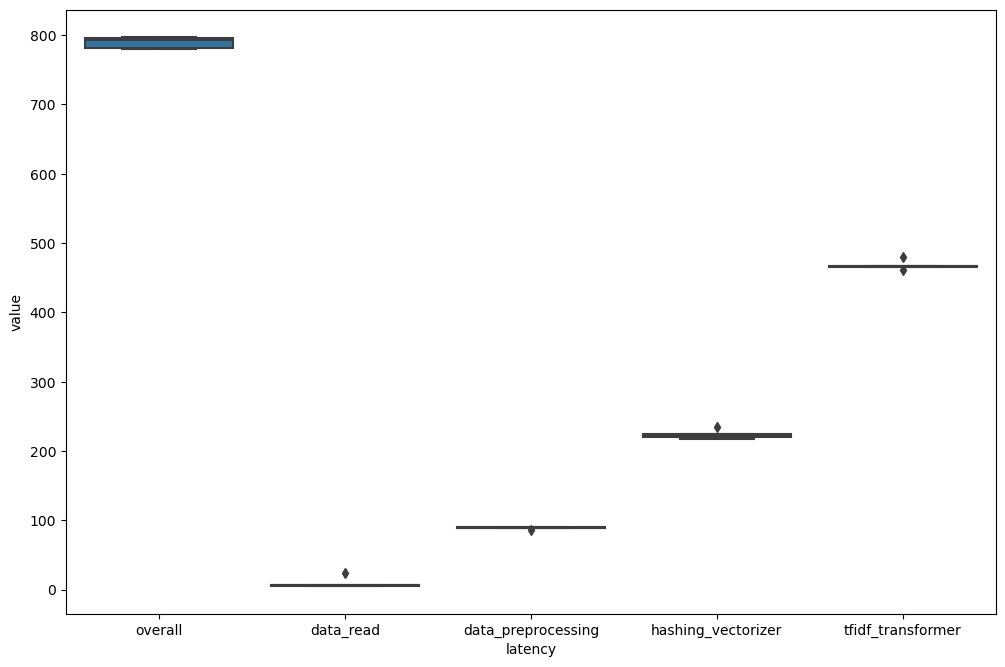

sample_run                     overall                data_read  \
                mean       std count        mean      std count      mean   
n_workers                                                                   
1                  2  1.581139     5  789.502847  8.37966     5  9.393355   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          7.770442     5          88.613268  ...     5         223.546858   

                          tfidf_transformer                     nrows       \
                std count              mean       std count      mean  std   
n_workers                                                                    
1          6.784544     5        467.949038  7.269362     5  20725971  0.0   

                 
          count  
n_workers        
1             5  

[1 rows x 21 columns]

In [8]:
data, melt_data = visualize_data(result_path) 
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy

## Benchmark latency without materializing the intermediate dataframe(s) except for the last stage

In [9]:
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
samples = 5
worker_counts = [1]
result_path = f"./results/result_poc_nlp_spark_{dataset}_nonpersist.pkl"

In [10]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, persist_flag=False)

  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

Workers:1, Sample Run:0, Finished loading data in 54409960s
Workers:1, Sample Run:0, Finished preprocessing data in 102781817s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 14274318s


21/08/03 19:37:41 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:0, Finished fitting IDF Transformer in 470589294058s


 20%|██████████████████████████████████▌                                                                                                                                          | 1/5 [07:54<31:39, 474.83s/it]

Workers:1, Sample Run:0, Finished executing full pipeline in 470761023140s
Workers:1, Sample Run:1, Finished loading data in 67689939s
Workers:1, Sample Run:1, Finished preprocessing data in 99841253s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 12950413s


21/08/03 19:45:37 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:1, Finished fitting IDF Transformer in 458658445764s


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 2/5 [15:37<23:22, 467.50s/it]

Workers:1, Sample Run:1, Finished executing full pipeline in 458839171790s
Workers:1, Sample Run:2, Finished loading data in 51357336s
Workers:1, Sample Run:2, Finished preprocessing data in 87697089s
Workers:1, Sample Run:2, Finished fitting HashVectorizer in 10941987s


21/08/03 19:53:17 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:2, Finished fitting IDF Transformer in 470433612398s


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3/5 [23:31<15:40, 470.47s/it]

Workers:1, Sample Run:2, Finished executing full pipeline in 470583901994s
Workers:1, Sample Run:3, Finished loading data in 52535169s
Workers:1, Sample Run:3, Finished preprocessing data in 84558421s
Workers:1, Sample Run:3, Finished fitting HashVectorizer in 11066808s


21/08/03 20:01:21 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:3, Finished fitting IDF Transformer in 473815182039s


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4/5 [31:28<07:53, 473.34s/it]

Workers:1, Sample Run:3, Finished executing full pipeline in 473963626055s
Workers:1, Sample Run:4, Finished loading data in 58796819s
Workers:1, Sample Run:4, Finished preprocessing data in 95945739s
Workers:1, Sample Run:4, Finished fitting HashVectorizer in 11418944s


21/08/03 20:09:08 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


Workers:1, Sample Run:4, Finished fitting IDF Transformer in 458229515549s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [39:10<00:00, 470.16s/it]

Workers:1, Sample Run:4, Finished executing full pipeline in 458395941288s
CPU times: user 1.28 s, sys: 415 ms, total: 1.69 s
Wall time: 39min 10s


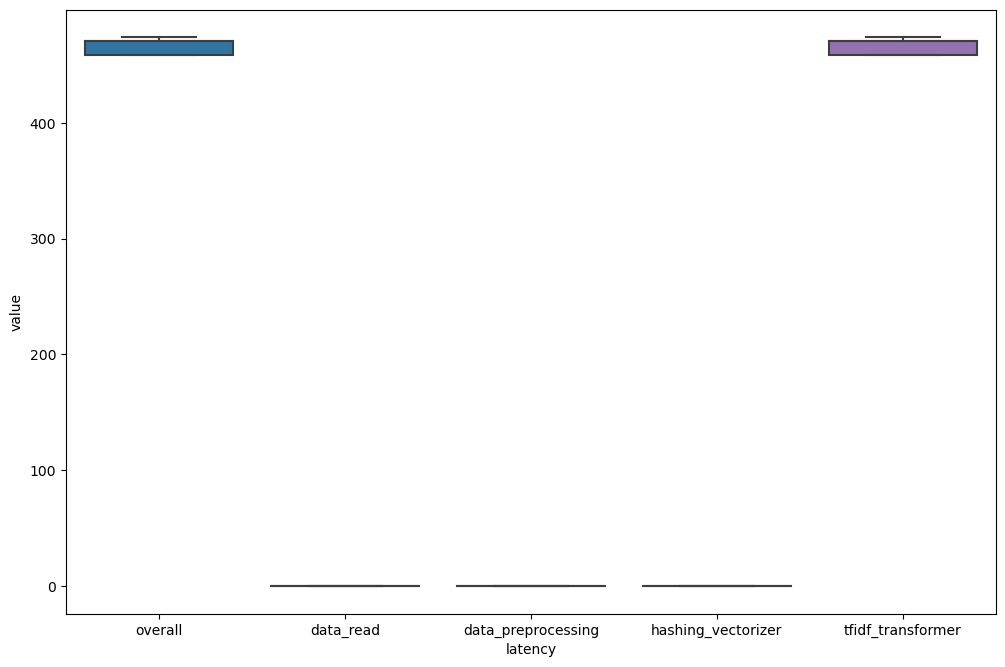

sample_run                     overall                 data_read  \
                mean       std count        mean       std count      mean   
n_workers                                                                    
1                  2  1.581139     5  466.508733  7.329802     5  0.056958   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          0.006633     5           0.094165  ...     5            0.01213   

                          tfidf_transformer                     nrows       \
                std count              mean       std count      mean  std   
n_workers                                                                    
1          0.001442     5         466.34521  7.339595     5  20725971  0.0   

                 
          count  
n_workers        
1             5  

[1 rows x 21 columns]

In [11]:
data, melt_data = visualize_data(result_path) 
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy